In [123]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import math

In [194]:
df = pd.read_csv('/content/drive/MyDrive/JHU Courses/Biomedical Data Design/Anti-Trafficking/Data/default_filled_simple.csv').sort_values(by='yearOfRegistration')

In [195]:
# Change year to string; Change other exploitation binary
df['yearOfRegistration'] = df['yearOfRegistration'].astype(int).astype(str)
df['isOtherExploit'] = df['isOtherExploit'].replace({0.0: 'No', 1.0: 'Yes'})

In [196]:
# Incorporate typing distribution to forced labour variables
df['forcedLabourType'] = 'None'

labour_dict = {
    'typeOfLabourAgriculture': 'Agriculture',
    'typeOfLabourConstruction': 'Construction',
    'typeOfLabourDomesticWork': 'Domestic Work',
    'typeOfLabourHospitality': 'Hospitality'
}

for labour_col, code in labour_dict.items():
    df.loc[(df['isForcedLabour'] == 1) & (df[labour_col] == 1), 'forcedLabourType'] = code

df.loc[(df['isForcedLabour'] == 1) & (df['forcedLabourType'] == 'None'), 'isForcedLabour'] = 0

In [197]:
# Incorporate typing distribution to sexual exploitation variables
df['sexualExploitType'] = 'None'

sex_dict = {
    'typeOfSexProstitution': 'Prostitution',
    'typeOfSexPornography': 'Pornography'
}

for sex_col, code in sex_dict.items():
    df.loc[(df['isSexualExploit'] == 1) & (df[sex_col] == 1), 'sexualExploitType'] = code

df.loc[(df['isSexualExploit'] == 1) & (df['sexualExploitType'] == 'None'), 'isSexualExploit'] = 0

In [198]:
# Incorporate typing distribution to means type variables
df['meansType'] = 'None'

means_dict = {
    'meansDebtBondageEarnings': 'Debt Bondage',
    'meansThreats': 'Threats',
    'meansAbusePsyPhySex': 'Abuse',
    'meansFalsePromises': 'False Promises',
    'meansDrugsAlcohol': 'Drugs',
    'meansDenyBasicNeeds': 'Deny Basic Needs',
    'meansExcessiveWorkHours': 'Excessive Work',
    'meansWithholdDocs': 'Withhold Docs',
}

for rec_col, code in means_dict.items():
    df.loc[df[rec_col] == 1, 'meansType'] = code

In [199]:
# Incorporate typing distribution to recruiter type variables
df['recruiterType'] = 'None'

recruiter_dict = {
    'recruiterRelationIntimatePartner': 'Intimate Partner',
    'recruiterRelationFriend': 'Friend',
    'recruiterRelationFamily': 'Family',
    'recruiterRelationOther': 'Other'
}

for rec_col, code in recruiter_dict.items():
    df.loc[df[rec_col] == 1, 'recruiterType'] = code

In [200]:
# Create variable dictionary
variable_categories = {}

for col in df.columns:
    unique_vals = df[col].dropna().unique()
    if np.issubdtype(df[col].dtype, np.number):
        cat_list = sorted(unique_vals)
    else:
        cat_list = sorted(unique_vals, key=str)
    variable_categories[col] = cat_list

for var, cats in variable_categories.items():
    print(f"{var}: {cats}")

yearOfRegistration: ['2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']
gender: ['Man', 'Trans/Transgender/NonConforming', 'Woman']
ageBroad: ['0--8', '09--17', '18--20', '21--23', '24--26', '27--29', '30--38', '39--47', '48+']
citizenship: ['AFG', 'ALB', 'BDI', 'BGD', 'BGR', 'BLR', 'BOL', 'BRA', 'CHN', 'CIV', 'COD', 'COL', 'DOM', 'ERI', 'ETH', 'GHA', 'GTM', 'HND', 'HTI', 'HUN', 'IDN', 'IND', 'JAM', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KOR', 'LAO', 'LKA', 'MDA', 'MDG', 'MEX', 'MMR', 'NER', 'NGA', 'NPL', 'PHL', 'ROU', 'RUS', 'SDN', 'SLE', 'SLV', 'SOM', 'SRB', 'THA', 'TJK', 'TKM', 'UGA', 'UKR', 'USA', 'UZB', 'VEN', 'VNM']
CountryOfExploitation: ['AFG', 'ALB', 'ARE', 'ARG', 'BDI', 'BGD', 'BGR', 'BIH', 'BLR', 'CAN', 'CHE', 'CHN', 'CIV', 'CZE', 'DEU', 'DNK', 'EGY', 'ESP', 'ETH', 'GBR', 'GHA', 'GRC', 'HKG', 'HTI', 'IDN', 'IND', 'IRQ', 'ITA', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', '

In [201]:
# Select certain columns for heat map
selected_columns = [
    'yearOfRegistration',
    'gender',
    'ageBroad',
    'citizenship',
    'CountryOfExploitation',
    'traffickMonths',
    'forcedLabourType',
    'sexualExploitType',
    'isOtherExploit',
    'meansType',
    'recruiterType'
]

df_selected = df[selected_columns].reset_index(drop=True)

In [203]:
# Convert values into categoricals
for col in df_selected.columns:
    df_selected[col] = df_selected[col].astype('category')

# Encode into integers codes
df_encoded = df_selected.apply(lambda s: s.cat.codes)

# Transpose
df_transposed = df_encoded.T

num_vars, num_people = df_transposed.shape

In [204]:
img_array = np.zeros((num_vars, num_people, 3))

legends = []

for i, var_name in enumerate(df_transposed.index):
    codes_for_this_row = df_transposed.iloc[i, :].values
    unique_codes = np.unique(codes_for_this_row)

    # Create a discrete palette for this variable
    # Can swap "Set2" for "tab10", "hsv", "Accent", etc.
    palette = sns.color_palette("Set2", n_colors=len(unique_codes))

    # Map each code to an RGB color
    code_to_color = {}
    for code_idx, cat_code in enumerate(unique_codes):
        code_to_color[cat_code] = palette[code_idx]

    # Fill the row of img_array
    for col_idx in range(num_people):
        code_val = codes_for_this_row[col_idx]
        rgb_color = code_to_color[code_val]
        img_array[i, col_idx, :] = rgb_color

    # Naming categories
    cat_series = df_selected[var_name]
    categories = list(cat_series.cat.categories)

    patches_for_var = []
    for cat_code in unique_codes:
        cat_label = categories[cat_code]
        color_rgb = code_to_color[cat_code]
        # Convert to a patch
        patch = mpatches.Patch(
            color=color_rgb,
            label=str(cat_label)
        )
        patches_for_var.append(patch)

    legends.append((var_name, patches_for_var))

In [205]:
variable_labels = [
    "Year Registered",
    "Gender",
    "Age Group",
    "Citizenship",
    "Country Exploited",
    "Months Trafficked",
    "Forced Labour (by type)",
    "Sexual Exploitation (by type)",
    "Other Exploitation?",
    "Trafficking Means (by type)",
    "Recruiter (by type)"
]

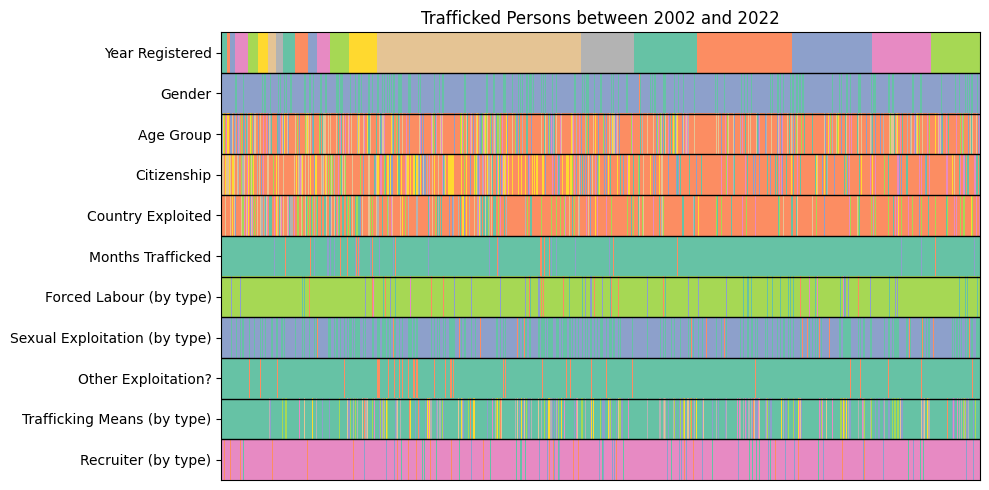

In [206]:
# Plot heat map
fig_matrix, ax_matrix = plt.subplots(figsize=(10, 5))
ax_matrix.imshow(img_array, aspect='auto')

# Turn off interpolation, set extent explicitly to 1
im = ax_matrix.imshow(
    img_array,
    interpolation='nearest',
    origin='upper',
    extent=[0, num_people, 0, num_vars],
    aspect='auto'
)

# Add thin black lines between each variable
for i in range(1, num_vars):
    ax_matrix.axhline(i, color='black', linewidth=1)

ax_matrix.set_yticks(np.arange(num_vars) + 0.5)
ax_matrix.set_yticklabels(variable_labels[::-1])

ax_matrix.set_xticks([])
ax_matrix.set_xticklabels([])

ax_matrix.set_title("Trafficked Persons between 2002 and 2022")

plt.tight_layout()
plt.show()

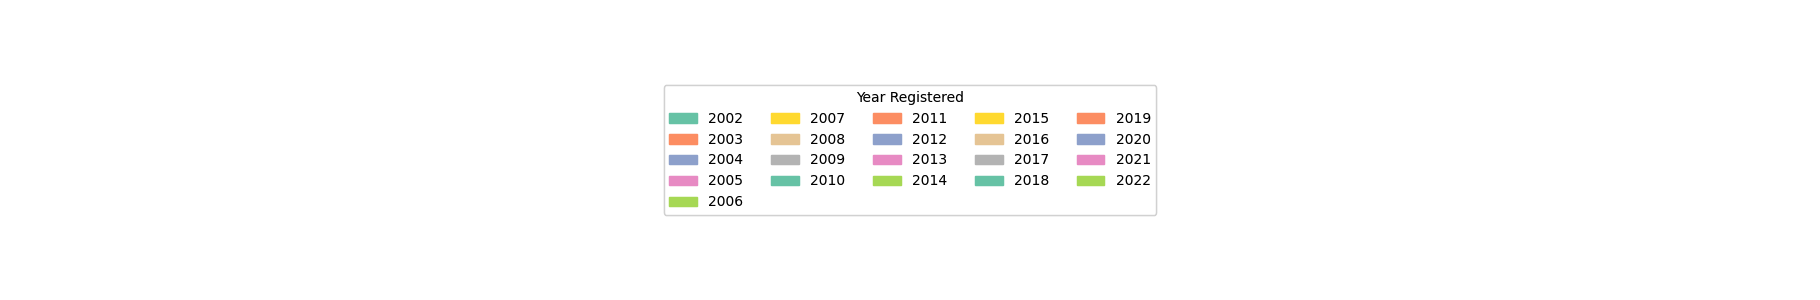

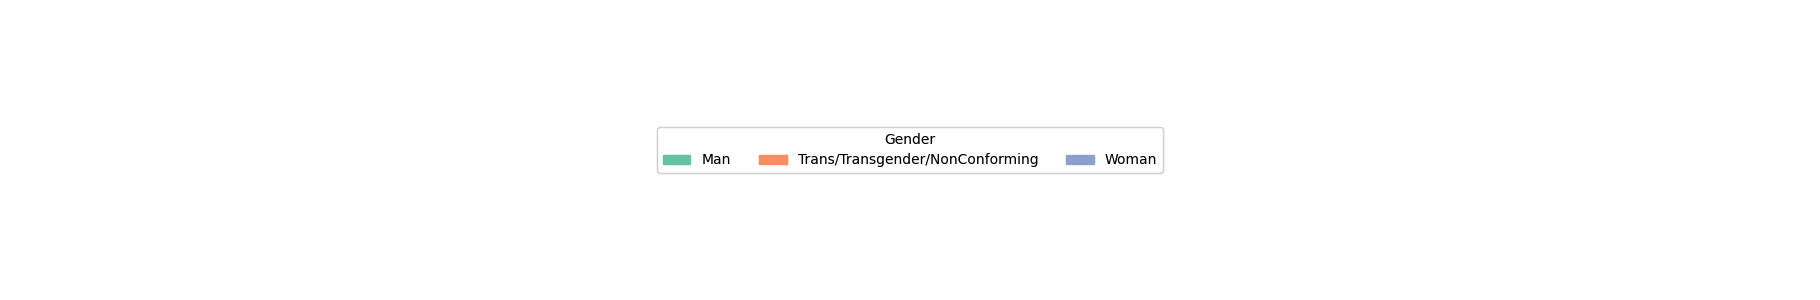

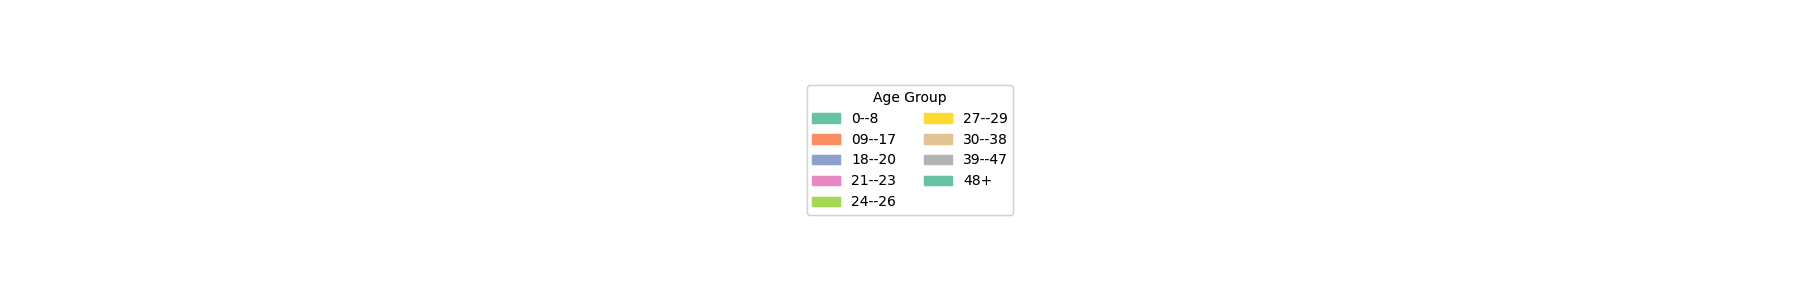

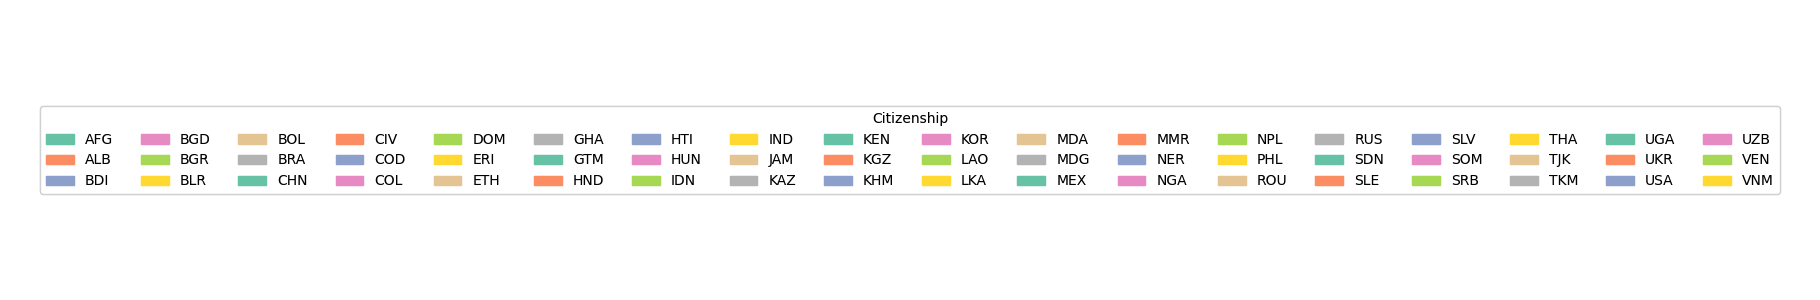

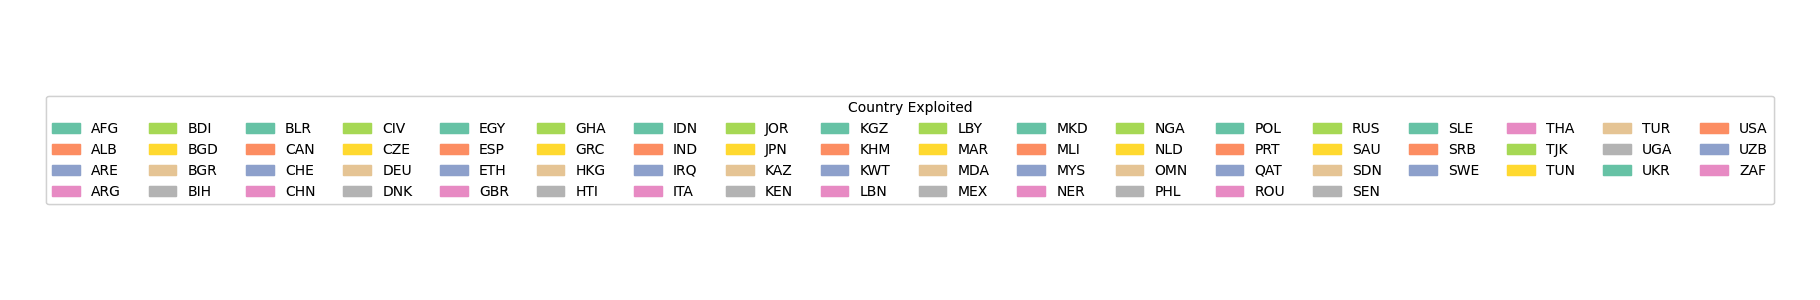

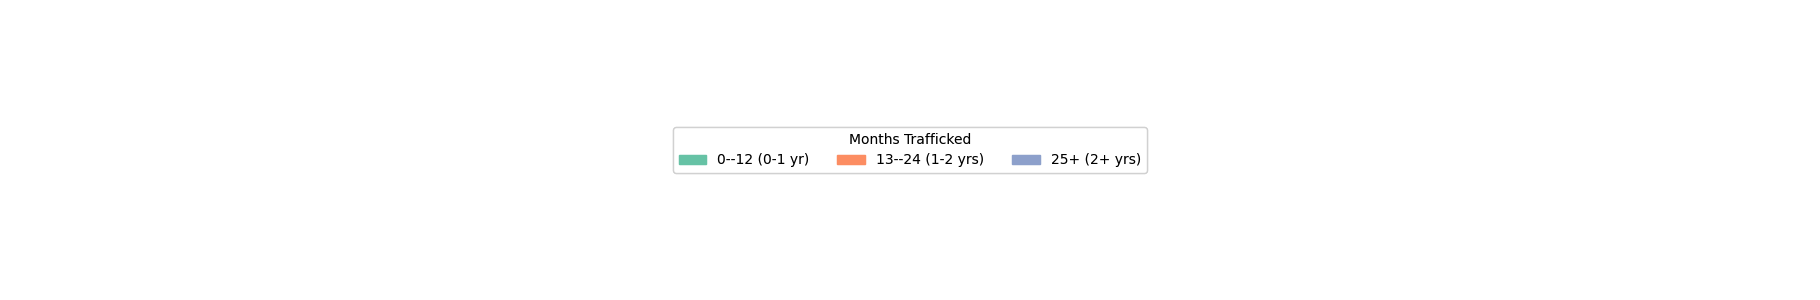

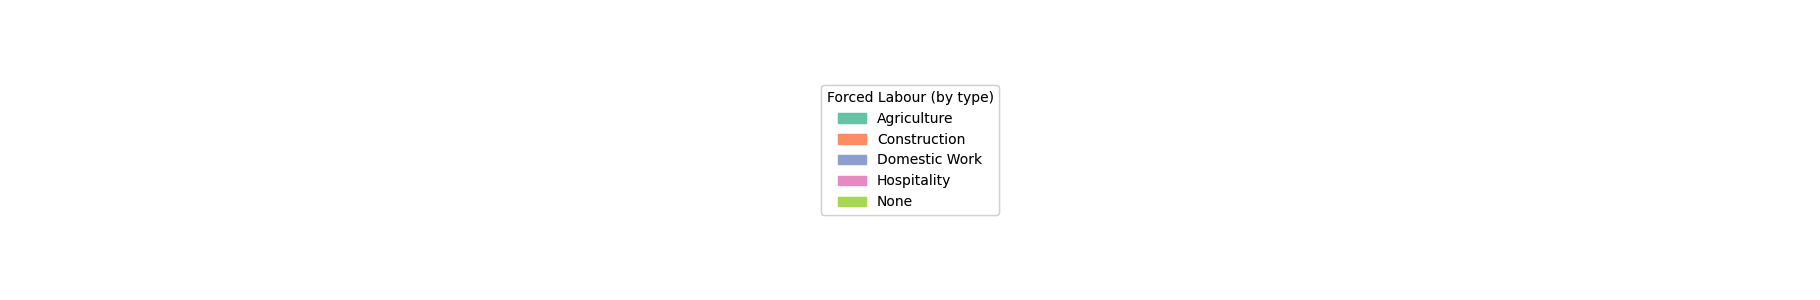

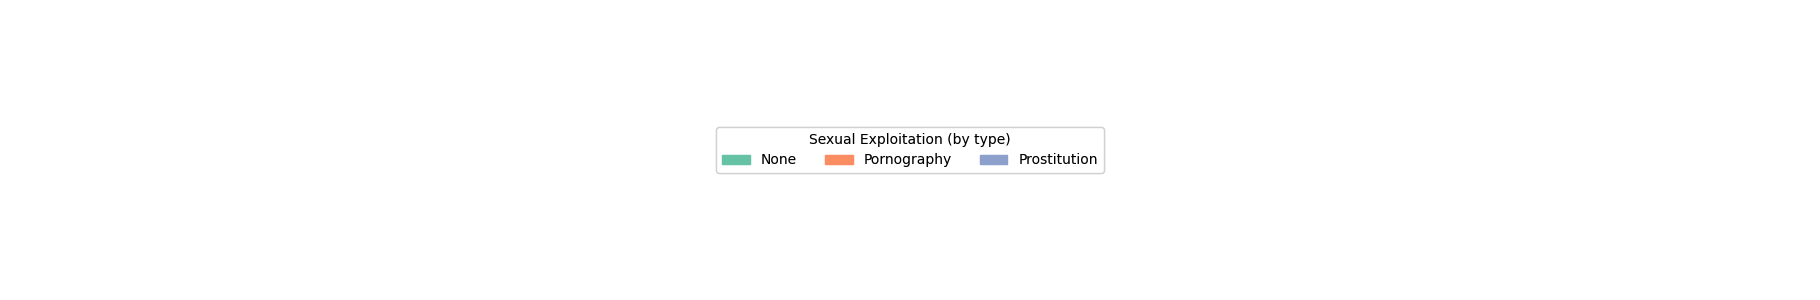

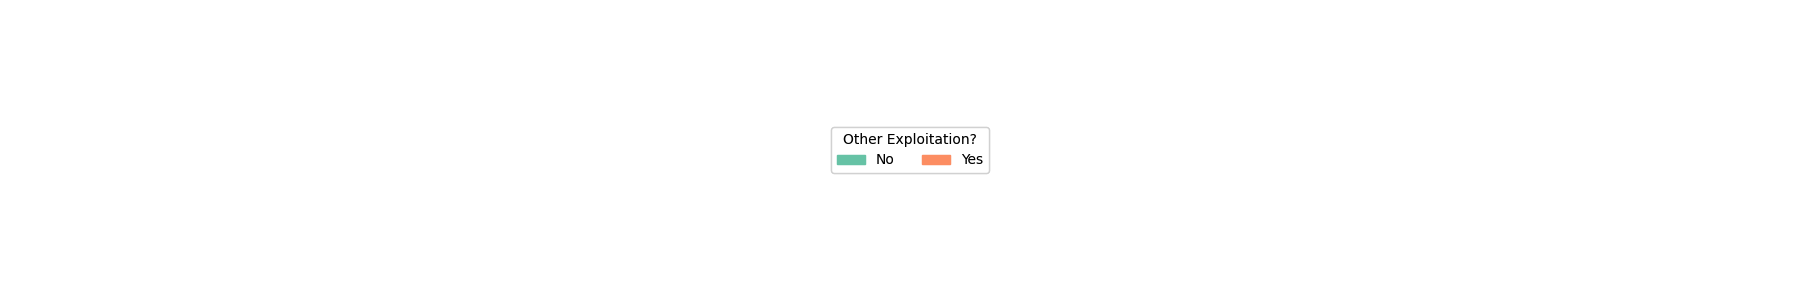

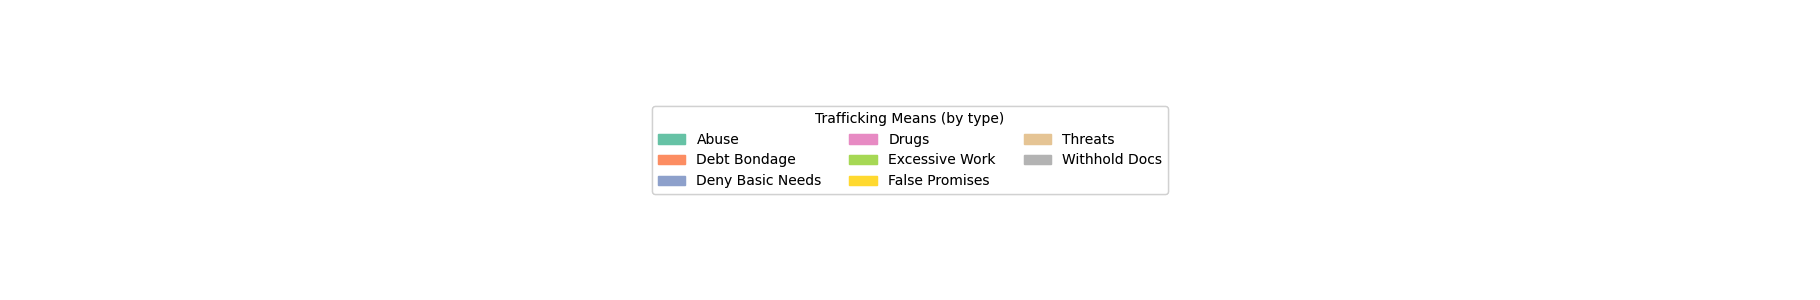

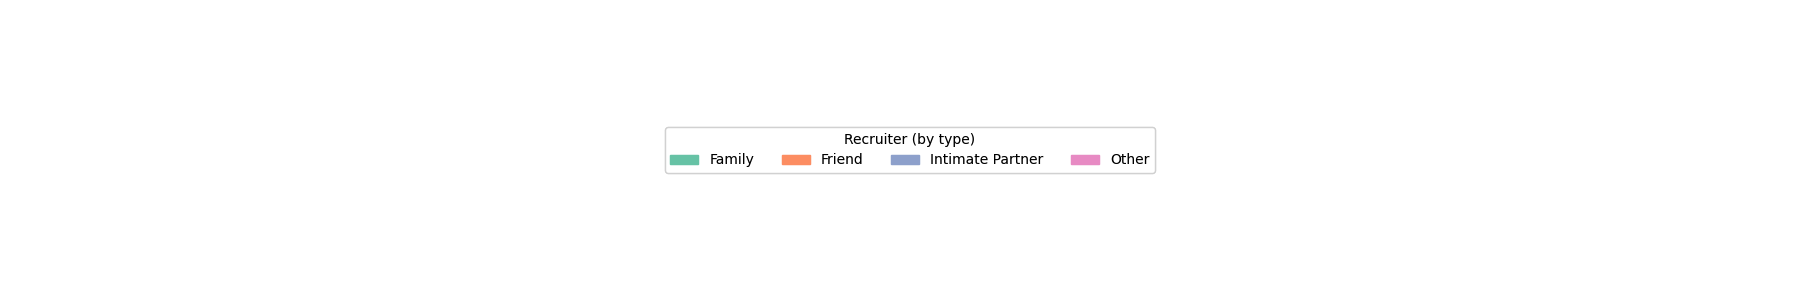

In [220]:
# Plot legends
custom_ncols = {
    'yearOfRegistration': 5,
    'gender': 3,
    'ageBroad': 2,
    'citizenship': 18,
    'CountryOfExploitation': 18,
    'traffickMonths': 4,
    'forcedLabourType': 1,
    'sexualExploitType': 3,
    'isOtherExploit': 2,
    'meansType': 3,
    'recruiterType': 4
}

for i, (var_name, patches_for_var) in enumerate(legends):
    # Increase figsize if you want more overall space
    fig_legend, ax_legend = plt.subplots(figsize=(30, 4))

    # Add additional padding/margins around the subplot
    fig_legend.subplots_adjust(
        left=0.2,    # more space on left
        right=0.8,   # more space on right
        top=0.85,    # more space at the top
        bottom=0.15  # more space at the bottom
    )

    ax_legend.axis("off")

    # Choose how many columns this legend should have
    ncol_value = custom_ncols.get(var_name, 1)

    # If you have matching display labels, use them
    legend_title = variable_labels[i]

    legend_obj = ax_legend.legend(
        handles=patches_for_var,
        title=legend_title,
        loc='center',
        ncol=ncol_value
    )
    ax_legend.add_artist(legend_obj)

    plt.show()

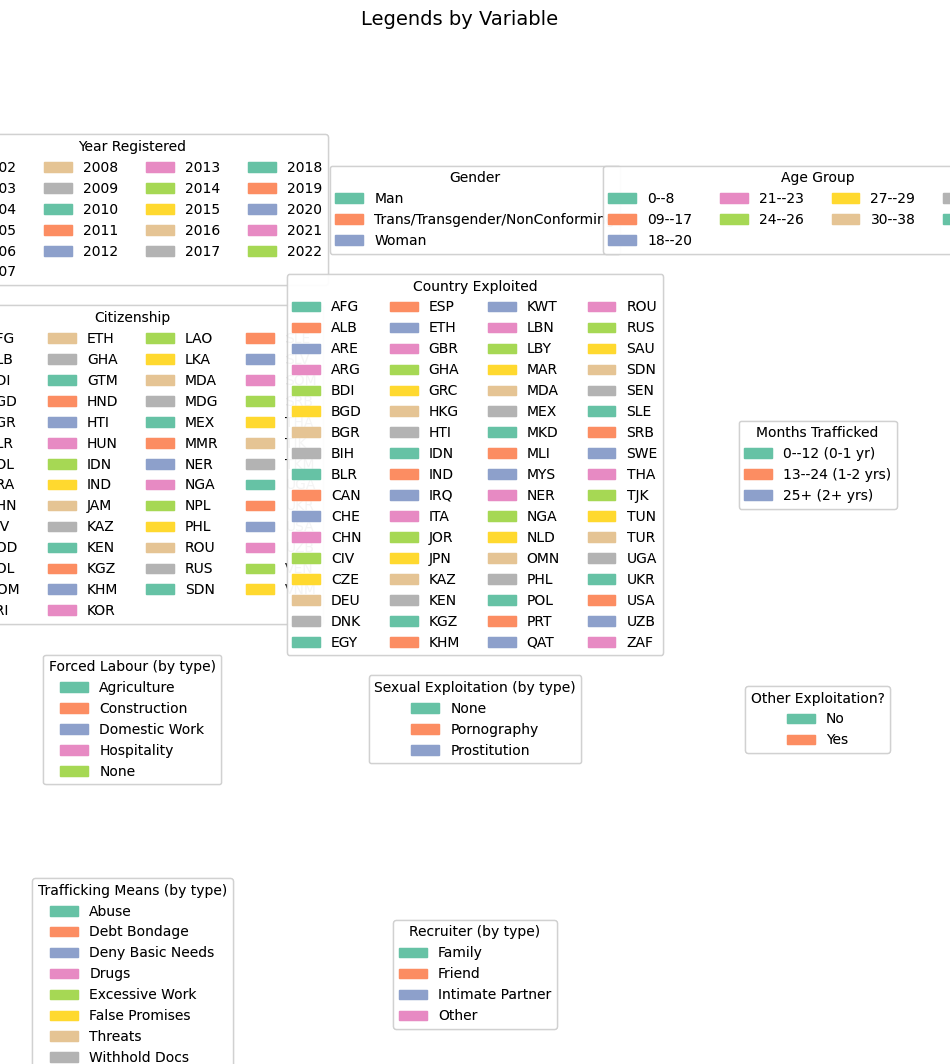

In [192]:
# Plot legends
num_cols = 3  # Adjust columns as desired
num_rows = math.ceil(num_vars / num_cols)

fig_legends, axes_legends = plt.subplots(
    nrows=num_rows, ncols=num_cols,
    figsize=(12, 3 * num_rows)  # Height depends on rows
)
axes_legends = axes_legends.flatten()  # Flatten to 1D array

fig_legends.suptitle("Legends by Variable", fontsize=14)

multi_col_vars = {"yearOfRegistration", "ageBroad", "citizenship", "CountryOfExploitation"}

for i, (var_name, patches_for_var) in enumerate(legends):
    ax = axes_legends[i]
    ax.axis("off")

    # Decide ncol based on name
    if var_name in multi_col_vars:
        ncol_value = 4
    else:
        ncol_value = 1

    legend_title = variable_labels[i]
    legend = ax.legend(
        handles=patches_for_var,
        title=legend_title,
        loc='center',
        ncol=ncol_value
    )
    ax.add_artist(legend)

# Turn off extra Axes if we have more subplots than legends
for j in range(i + 1, len(axes_legends)):
    axes_legends[j].axis("off")

fig_legends.subplots_adjust(
    wspace=0.4,  # horizontal space between subplots
    hspace=0.6   # vertical space between subplots
)

plt.show()